# Exploring UMAP on a graph - Part 2 - Adjacency as Similarity

Towards [Experiment #2: Evaluate UMAP(+HDBSCAN) as a graph embedding(clustering) algorithm](https://github.com/acwooding/HighDimensionalClustering/wiki/Experiments-to-Try). All notation is as in that post. 

Moving on from the complete graph example, let's more generally consider what happens when we consider two nodes similar if they are adjacent aka. give distance 1 when there is an edge and otherwise distance is $\infty$ (often using 1000 instead of $\infty$ since the precomputed code path doesn't take sparse matrices).

**Questions**:
* What structures are preserved from $X$ to $V(X)$ when using adjacency as similarity? What is not preserved? Explore cliques for this.
* It seems like the $k$ relative to the degree distribution should matter...quantify this? Compare with randomly removing edges.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
import umap.plot
import scipy
import pandas as pd

import igraph as ig

from IPython.core.display import display, SVG

from src import paths

sns.set()

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

Some helper functions to access $U(X)$ and $V(X)$

In [4]:
from src.custom.utils import get_graph_UX, get_VX_from_UX, adjacency_to_distance_matrix, randomly_remove_edges

# Small Toy Example

Let's look at what happens to cliques as $k$ varies with a small toy example. 

Let $n$ be the number of nodes in our graph $X$

In [5]:
n = 20

Create the adjacency matrix $M$ of a graph $X$

In [6]:
M = np.array([[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], 
              [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], 
              [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], 
              [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1], 
              [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0], 
              [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1], 
              [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1], 
              [1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], 
              [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], 
              [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0], 
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], 
              [0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1], 
              [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1], 
              [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1], 
              [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], 
              [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0], 
              [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1], 
              [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0]])

In [7]:
G = ig.Graph.Weighted_Adjacency(M, 'undirected')

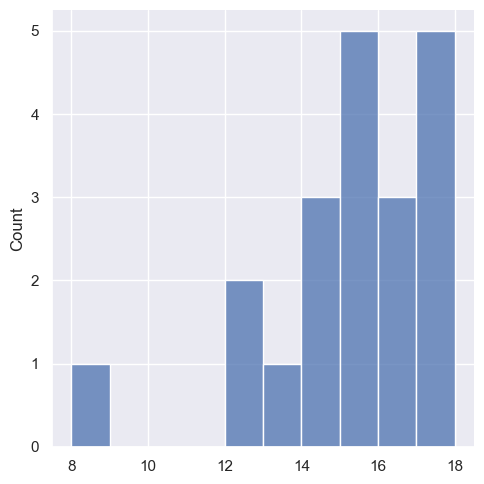

In [8]:
sns.displot(G.degree(), bins=10);

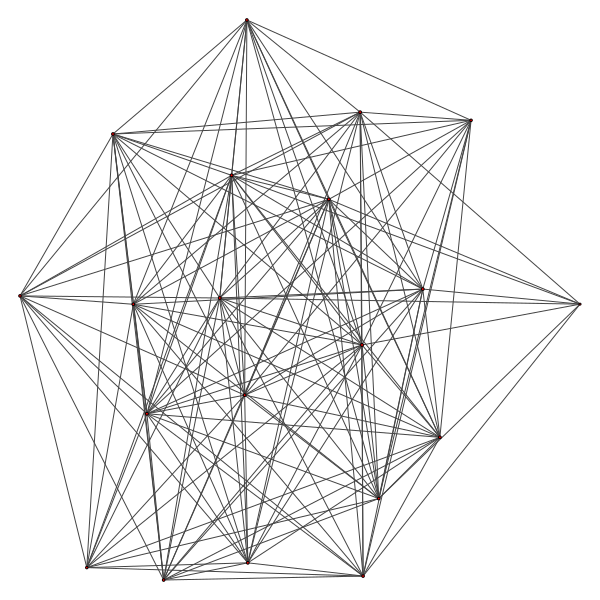

In [9]:
ig.plot(G, vertex_size=np.log(G.vs.degree()))

## Get $U(X)$

Some fixed parameters

In [10]:
random_state = 42
metric = 'precomputed'

Let's add some noise to the distances to simulate randomly choosing the $k^{th}$ neighbour in a tie-break situation and turning the matix into a sparse matrix to give distance 1 when there is an edge and otherwise (using 1000 instead of $\infty$ since the precomputed code path doesn't take sparse matrices)

In [11]:
N = adjacency_to_distance_matrix(M)

Let's start with $k=7$, about half of the mean degree of $X$.

In [12]:
k = 7

In [13]:
ux = get_graph_UX(N,
                 n_neighbors=k,
                 random_state=random_state,
                 metric=metric)

In [14]:
np.unique(ux.indegree(), return_counts=True)

(array([ 3,  5,  6,  7,  9, 10]), array([2, 2, 2, 8, 4, 2]))

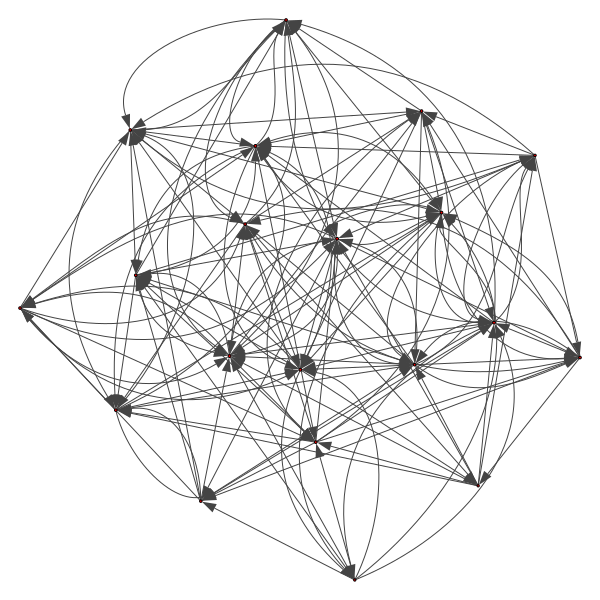

In [15]:
ig.plot(ux, vertex_size=np.log(ux.vs.degree()))

And $V(X)$ (assuming fuzzy union)

In [16]:
set_op_mix_ratio = 1.0
vx = get_VX_from_UX(ux.get_adjacency_sparse(), set_op_mix_ratio)

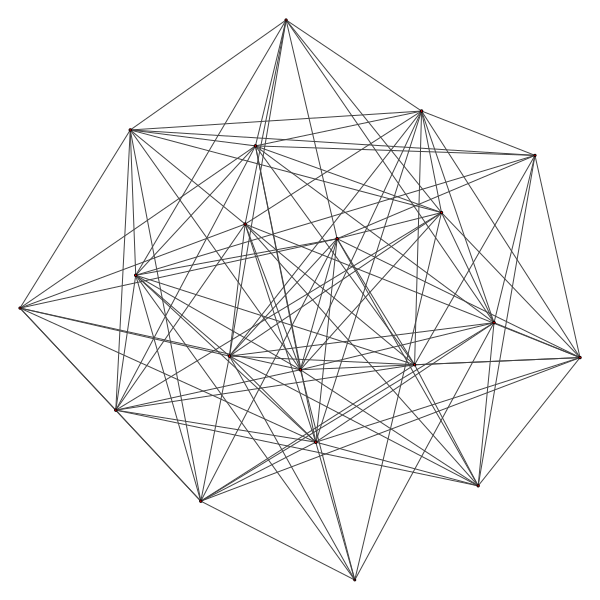

In [17]:
ig.plot(vx, vertex_size=np.log(vx.vs.degree()))

Let's look at how many edges are preserved:

In [18]:
M.sum()

296

In [19]:
vx.get_adjacency_sparse().sum()

220

Double check we don't have any new edges

In [20]:
(M - vx.get_adjacency_sparse()).sum()

76

Compare degree distributions

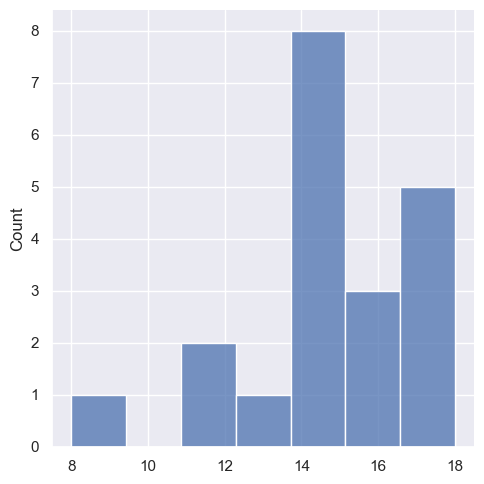

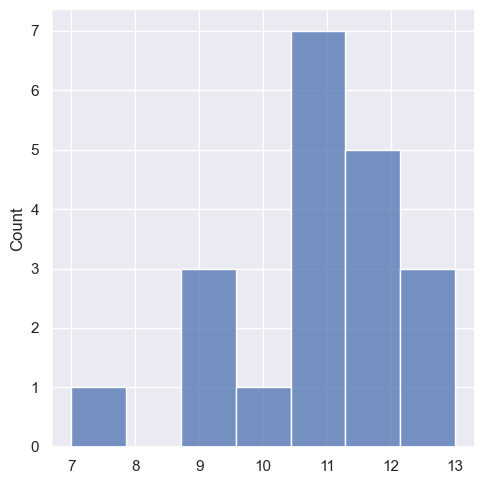

In [21]:
sns.displot(G.degree())
sns.displot(vx.degree());

Look at the number of cliques preserved

In [22]:
size_max_clique = max([len(x) for x in G.maximal_cliques()])

In [23]:
for k in range(3, size_max_clique + 1):
    print(f'number of {k}-cliques:, {len(G.cliques(min=k, max=k))}')

number of 3-cliques:, 550
number of 4-cliques:, 1149
number of 5-cliques:, 1419
number of 6-cliques:, 1055
number of 7-cliques:, 464
number of 8-cliques:, 111
number of 9-cliques:, 11


In [24]:
for m in range(3, k):
    print(f'number of {m}-cliques:, {len(vx.cliques(min=m, max=m))}')

number of 3-cliques:, 203
number of 4-cliques:, 120
number of 5-cliques:, 16
number of 6-cliques:, 0
number of 7-cliques:, 0
number of 8-cliques:, 0


Assuming fuzzy union, here's the 2D embedding we get:

In [25]:
X_rep = umap.UMAP(n_neighbors=k,
                  random_state=random_state,
                  metric=metric).fit(N)
G.vs['layout'] = X_rep.embedding_

Here's a plot of the original graph using the UMAP node embedding placement (the graph using umap layout has red nodes, and the igraph layout has green nodes). 

It seems to do a decent job.

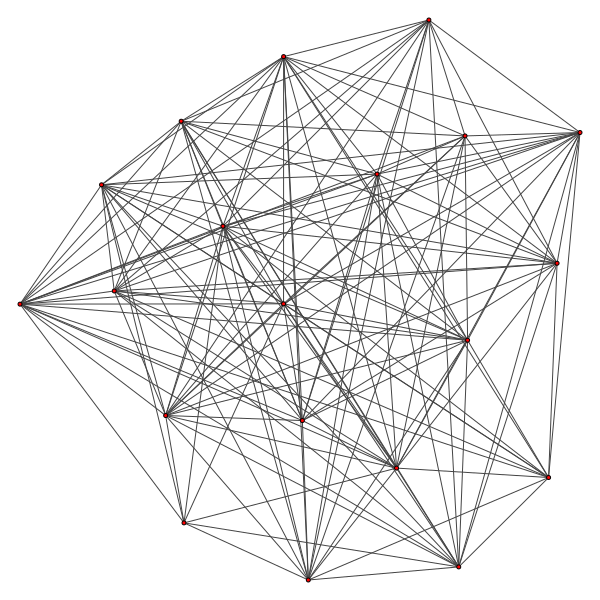

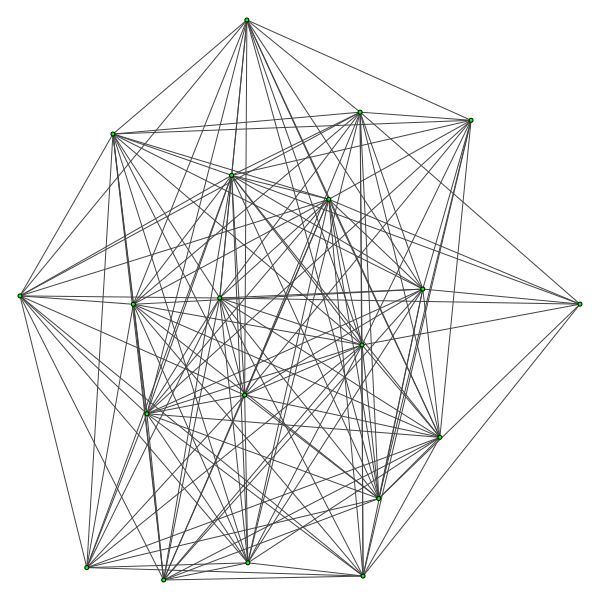

In [26]:
display(SVG(ig.plot(G, layout = G.vs['layout'], vertex_size=4, vertex_color='red')._repr_svg_()[0]))
display(SVG(ig.plot(G, vertex_size=4, vertex_color='green')._repr_svg_()[0]))

# Now with varying $k$

Let's see how far we have to go with $k$ so that $V(X)$ is all of $X$.

In [27]:
num_edges = M.sum()
for k in range(3, max(G.degree())):
    print(f'\n{k} \n ----------------------')
    ux = get_graph_UX(N,
                 n_neighbors=k,
                 random_state=random_state,
                 metric=metric)
    vx = get_VX_from_UX(ux.get_adjacency_sparse())
    is_identity = (vx.get_adjacency_sparse().todense() == M).all()
    print(f'Identity from X to V(X): {is_identity}')
    if not is_identity:
        print(f'proportion of edges preserved: {vx.get_adjacency_sparse().sum()/num_edges}')
        for j in range(3, min((k + 2), size_max_clique)):
            print(f'number of {j}-cliques in V(X): {len(vx.cliques(min=j, max=j))}')


3 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.35135135135135137
number of 3-cliques in V(X): 15
number of 4-cliques in V(X): 0

4 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.4864864864864865
number of 3-cliques in V(X): 50
number of 4-cliques in V(X): 6
number of 5-cliques in V(X): 0

5 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.5608108108108109
number of 3-cliques in V(X): 84
number of 4-cliques in V(X): 24
number of 5-cliques in V(X): 4
number of 6-cliques in V(X): 0

6 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.6621621621621622
number of 3-cliques in V(X): 140
number of 4-cliques in V(X): 55
number of 5-cliques in V(X): 6
number of 6-cliques in V(X): 0
number of 7-cliques in V(X): 0

7 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.7432432432432432
number of 3-c

Note that once $k$ was close enought to the max degree we recovered the entirety of the initial graph with $V(X)$. 

# A Slightly Bigger Toy Example

Let's look at a graph with 100 nodes and roughly 50 edges per node. 

In [28]:
n = 100

In [29]:
param = 0.7
N = np.random.rand(n,n)
N[N < param] = 0
N[N >= param] = 1

In [30]:
H = ig.Graph.Weighted_Adjacency(N, 'directed')
G = H.simplify().as_undirected()
M = G.get_adjacency_sparse().todense()

In [31]:
N = adjacency_to_distance_matrix(M)

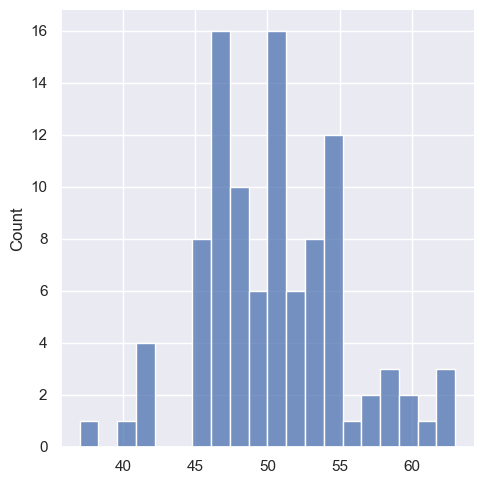

In [32]:
plt = sns.displot(G.degree(), bins=20)
#plt.savefig(paths['figures_path'] / "100_hc_deg_distribution.png")

Compute all the steps for varying $k$. Note how far we have to go to get to the identity map from $X$ to $V(X)$.

In [33]:
max_clique_size = max(np.unique([len(x) for  x in G.maximal_cliques()]))
max_clique_size

9

In [34]:
k_n_cliques = {}
ux_graphs = {}
vx_graphs = {}
embeddings = {}
num_edges = M.sum()

for k in np.arange(3, max(G.degree())+5, 5):
    print(f'\n{k} \n ----------------------')
    ux = get_graph_UX(N,
                 n_neighbors=k,
                 random_state=random_state,
                 metric=metric)
    ux_graphs[k] = ux
    set_op_mix_ratio = 1.0
    vx = get_VX_from_UX(ux.get_adjacency_sparse(), set_op_mix_ratio)
    is_identity = (vx.get_adjacency_sparse().todense() == M).all()
    X_rep = umap.UMAP(n_neighbors=k,
                  random_state=random_state,
                  metric=metric).fit(N)
    vx.vs['layout'] = X_rep.embedding_
    vx_graphs[k] = vx
    embeddings[k] = X_rep
    print(f'Identity from X to V(X): {is_identity}')
    if not is_identity:
        print(f'proportion of edges preserved: {vx.get_adjacency_sparse().sum()/num_edges}')

        d = {}
        for j in range(2, max_clique_size+1):
            d[j] = len(vx.cliques(min=j, max=j))
        k_n_cliques[k] = d
    else:
        identity_k = k
        break


3 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.11578112609040445

8 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.29381443298969073

13 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.4555908009516257

18 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.5896114195083267

23 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.7085646312450437

28 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.8092783505154639

33 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.8897700237906423

38 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.9452815226011102

43 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.9813639968279143

48 
 ----

## Preserving Cliques

Let's take a look at how many cliques are preserved of different sizes while varying `n_neighbors`

In [35]:
max_clique_size = max(np.unique([len(x) for  x in G.maximal_cliques()]))
max_clique_size

9

In [36]:
n_cliques = {}
for j in range(2, max_clique_size+1):
    n_cliques[j] = len(G.cliques(min=j, max=j))
    print(f'number of {j}-cliques in G: {n_cliques[j]}')

number of 2-cliques in G: 2522
number of 3-cliques in G: 21353
number of 4-cliques in G: 68295
number of 5-cliques in G: 87926
number of 6-cliques in G: 47248
number of 7-cliques in G: 10767
number of 8-cliques in G: 1045
number of 9-cliques in G: 40


In [37]:
proportion = {}
for j in range(2, max_clique_size+1):
    d = {}
    for a in np.arange(3, identity_k, 5):
        d[a] = int(k_n_cliques[a][j] / n_cliques[j] * 100)
    d[identity_k] = 100 # add for completion based on when X -> V(X) is the identity
    proportion[j]= d

In [38]:
df = pd.DataFrame(proportion)

In [39]:
df

,2,3,4,5,6,7,8,9
3,11,0,0,0,0,0,0,0
8,29,2,0,0,0,0,0,0
13,45,8,0,0,0,0,0,0
18,58,19,3,0,0,0,0,0
23,70,34,10,2,0,0,0,0
28,80,51,25,9,2,0,0,0
33,88,69,46,27,13,5,1,0
38,94,83,68,51,35,22,12,7
43,98,93,87,78,69,61,57,60
48,99,98,96,93,89,84,77,72


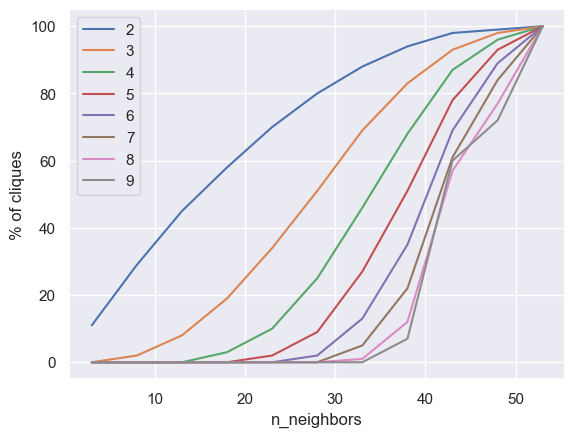

In [40]:
ax = df.plot(xlabel='n_neighbors', ylabel='% of cliques');
#ax.get_figure().savefig(paths['figures_path'] / "100_hc_cliques.png")

This seems to make sense when we review the degree distribution of the graph $X$ (which is more or less normally distributed). And because of proportionally keeping more edges from low degree nodes (where low degree is defined by degree less than `n_neighbors`, we see that the larger cliques take a while to get preserved.

In [41]:
degree = G.degree()
mean = np.mean(degree)
print(f'mean: {mean}, variance:{np.var(degree)}')

mean: 50.44, variance:23.506400000000003


In particular, when `n_neighbors` hits the mean most of the edges from the original graph $X$ will be in $V(X)$. 

The degree distribution of $V(X)$ stays normal, and the mean and variance in the degree distribution grows as $k$ grows. 

3:, mean: 5.84, variance:2.5944000000000007
8:, mean: 14.82, variance:7.7676
13:, mean: 22.98, variance:8.4196
18:, mean: 29.74, variance:11.0324
23:, mean: 35.74, variance:11.4524
28:, mean: 40.82, variance:13.4876
33:, mean: 44.88, variance:14.605600000000003
38:, mean: 47.68, variance:16.277599999999996
43:, mean: 49.5, variance:18.85
48:, mean: 50.24, variance:21.422400000000003


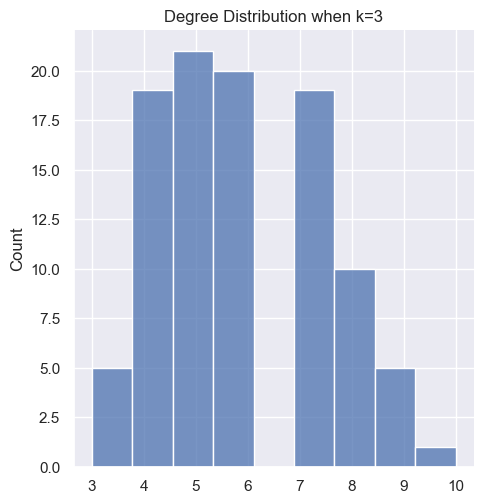

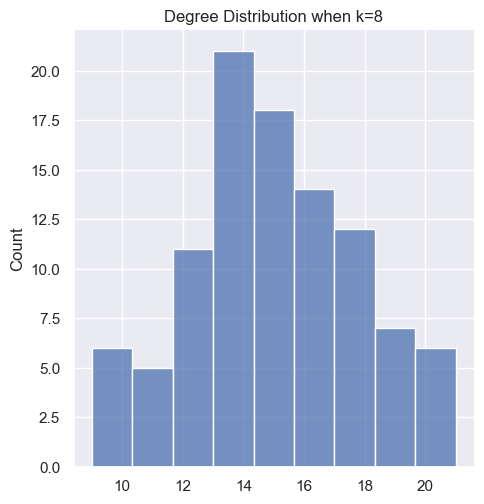

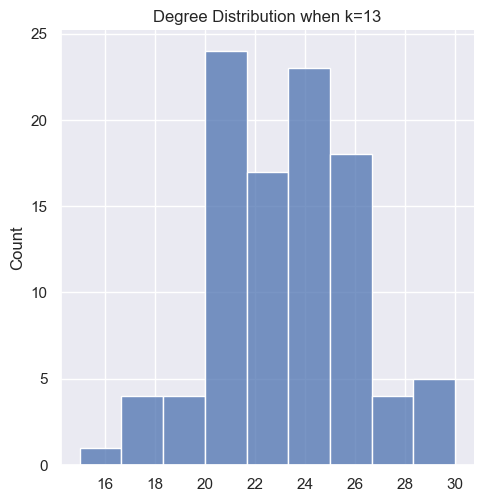

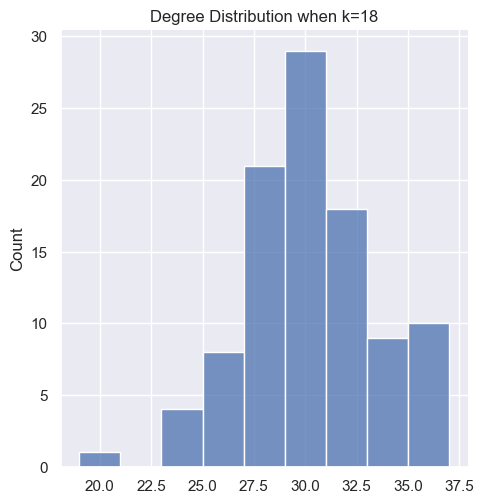

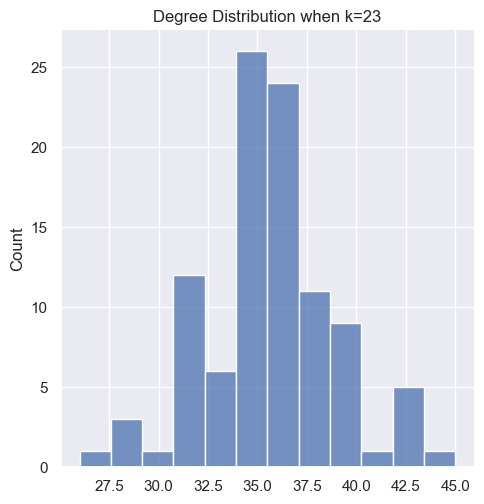

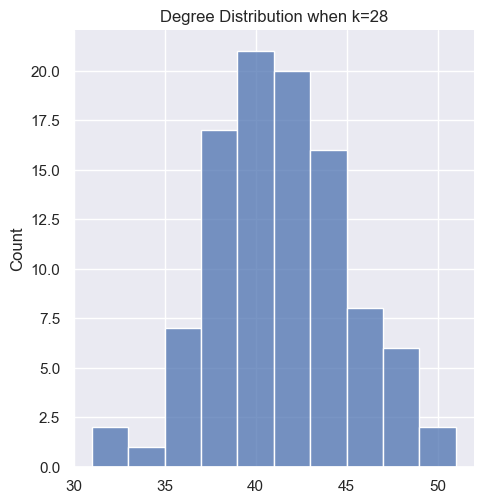

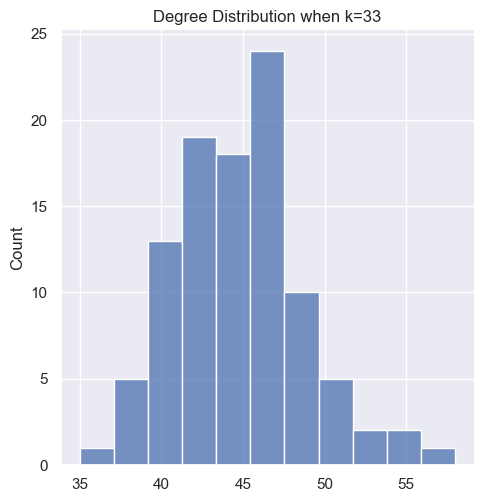

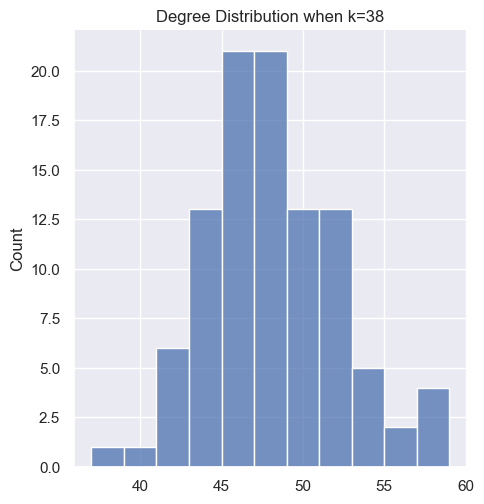

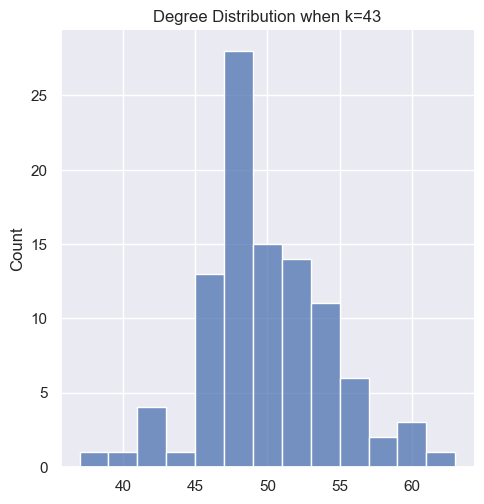

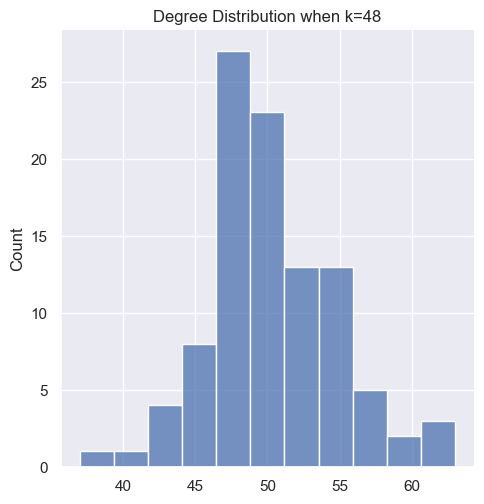

In [42]:
deg = {}
for i, a in enumerate(np.arange(3, identity_k, 5)):
    degree = vx_graphs[a].degree()
    mean = np.mean(degree)
    print(f'{a}:, mean: {mean}, variance:{np.var(degree)}')
    deg[a] = degree - mean
    sns.displot(degree).set(title=f"Degree Distribution when k={a}")

This suggests (although by no surprise) a relationship between the number of cliques preserved, `n_neighbors` and the degree distribution of the graph. Because we're choosing the adjacency as similarity, we can think of what we're doing as preserving adjacency, which should also preserve something of the degree distribution. For low degree nodes (nodes with degree less than $k$), the local neighbourhood is preserved exactly. However, connections between high degree nodes (degree greater than $k$) get thinned, as $U(X)$ only keeps $k$ outgoing edges for each high degree node. 

## Compare with randomly removing edges

In [43]:
rx_k_n_cliques = {}
rx_graphs = {}
num_edges = M.sum()

for k in np.arange(3, identity_k, 5):
    print(f'\n{k} \n ----------------------')
    rx_mat = randomly_remove_edges(M, k_n_cliques[k][2] / n_cliques[2])
    rx = ig.Graph.Weighted_Adjacency(rx_mat, 'undirected')
    is_identity = (rx_mat.todense() == M).all()
    rx_graphs[k] = rx
    print(f'Identity from X to R(X): {is_identity}')
    if not is_identity:
        print(f'proportion of edges preserved: {rx_mat.sum()/num_edges}')

        d = {}
        for j in range(2, max_clique_size+1):
            d[j] = len(rx.cliques(min=j, max=j))
        rx_k_n_cliques[k] = d
    else:
        break


3 
 ----------------------
Identity from X to R(X): False
proportion of edges preserved: 0.11578112609040445

8 
 ----------------------
Identity from X to R(X): False
proportion of edges preserved: 0.29381443298969073

13 
 ----------------------
Identity from X to R(X): False
proportion of edges preserved: 0.4555908009516257

18 
 ----------------------
Identity from X to R(X): False
proportion of edges preserved: 0.5896114195083267

23 
 ----------------------
Identity from X to R(X): False
proportion of edges preserved: 0.7085646312450437

28 
 ----------------------
Identity from X to R(X): False
proportion of edges preserved: 0.8092783505154639

33 
 ----------------------
Identity from X to R(X): False
proportion of edges preserved: 0.8897700237906423

38 
 ----------------------
Identity from X to R(X): False
proportion of edges preserved: 0.9452815226011102

43 
 ----------------------
Identity from X to R(X): False
proportion of edges preserved: 0.9813639968279143

48 
 ----

## Preserving Cliques

Let's take a look at how many cliques are preserved of different sizes while varying `n_neighbors`

In [44]:
rx_proportion = {}
for j in range(2, max_clique_size+1):
    rx_d = {}
    for a in np.arange(3, identity_k, 5):
        rx_d[a] = int(rx_k_n_cliques[a][j] / n_cliques[j] * 100)
    rx_d[identity_k] = 100 # add for completion based on when X -> V(X) is the identity
    rx_proportion[j]= rx_d

In [45]:
rx_df = pd.DataFrame(rx_proportion)

In [46]:
df

,2,3,4,5,6,7,8,9
3,11,0,0,0,0,0,0,0
8,29,2,0,0,0,0,0,0
13,45,8,0,0,0,0,0,0
18,58,19,3,0,0,0,0,0
23,70,34,10,2,0,0,0,0
28,80,51,25,9,2,0,0,0
33,88,69,46,27,13,5,1,0
38,94,83,68,51,35,22,12,7
43,98,93,87,78,69,61,57,60
48,99,98,96,93,89,84,77,72


In [47]:
rx_df

,2,3,4,5,6,7,8,9
3,11,0,0,0,0,0,0,0
8,29,2,0,0,0,0,0,0
13,45,9,0,0,0,0,0,0
18,58,20,4,0,0,0,0,0
23,70,35,12,2,0,0,0,0
28,80,53,29,13,5,1,0,0
33,88,70,48,29,15,7,3,2
38,94,84,71,56,40,26,14,0
43,98,94,89,83,77,69,61,52
48,99,98,97,96,94,91,91,95


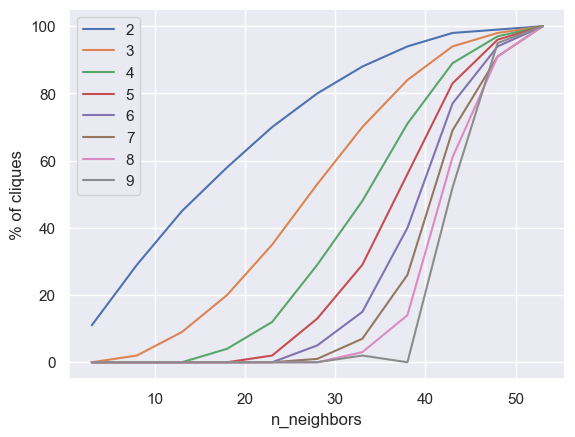

In [48]:
ax = rx_df.plot(xlabel='n_neighbors', ylabel='% of cliques');
#ax.get_figure().savefig(paths['figures_path'] / "100_hc_cliques_rx.png")

Let's see how the degree distribution compares:

3:, mean: 5.84, variance:5.954400000000001
8:, mean: 14.82, variance:13.027600000000001
13:, mean: 22.98, variance:14.719599999999998
18:, mean: 29.74, variance:17.7924
23:, mean: 35.74, variance:18.912399999999998
28:, mean: 40.82, variance:27.427599999999995
33:, mean: 44.88, variance:23.5856
38:, mean: 47.68, variance:24.937599999999996
43:, mean: 49.5, variance:24.87
48:, mean: 50.24, variance:23.882400000000004


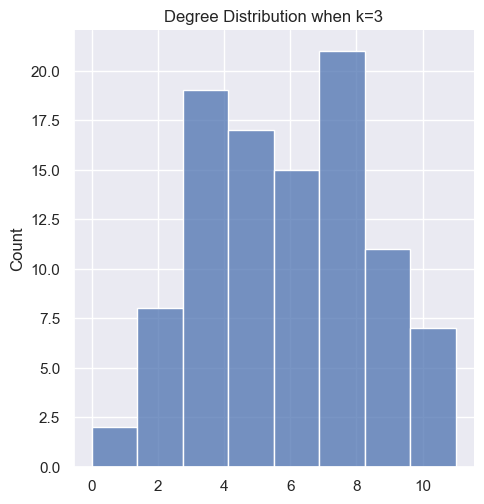

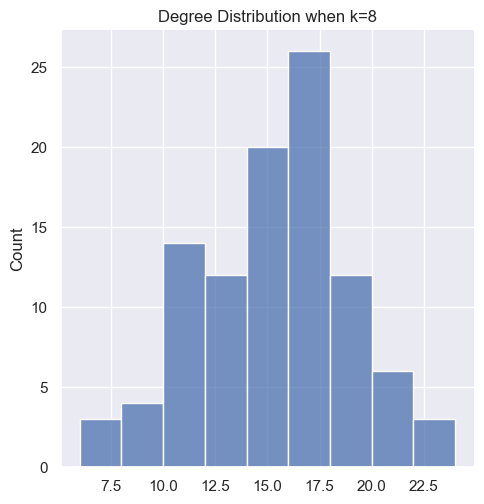

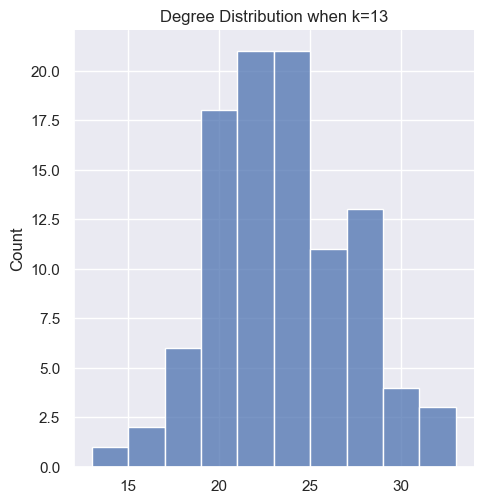

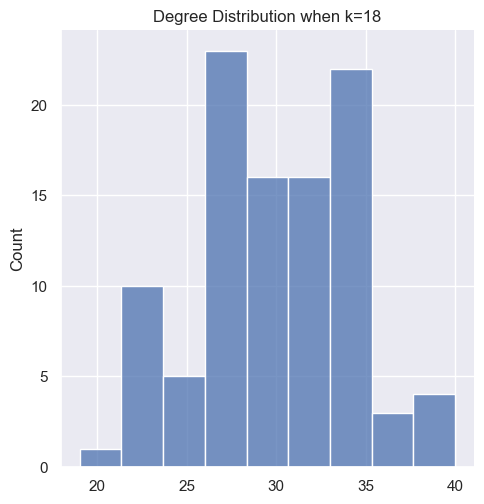

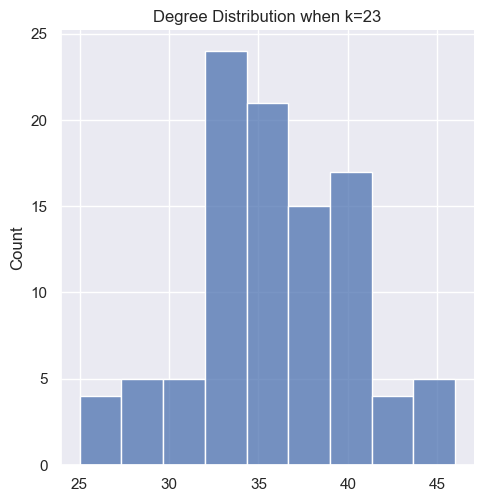

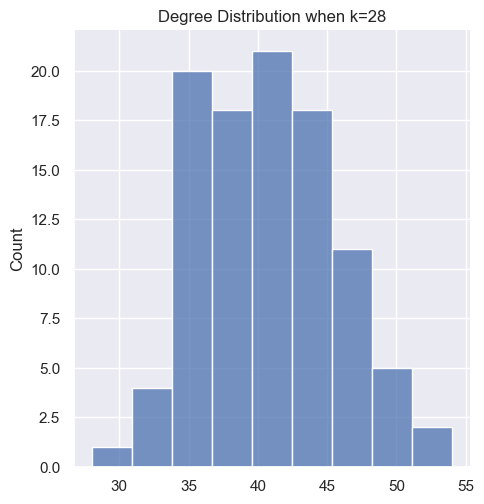

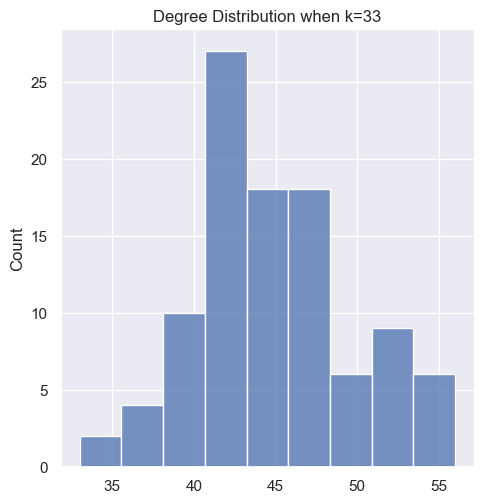

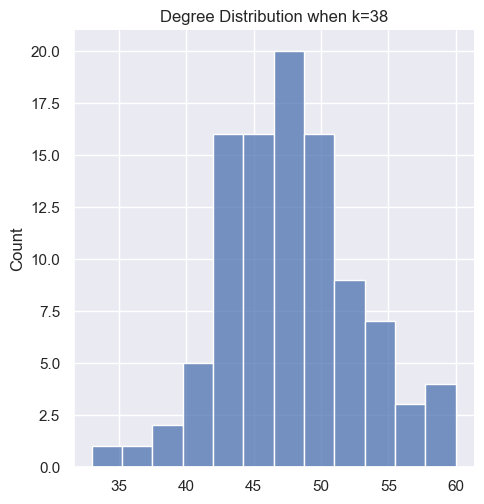

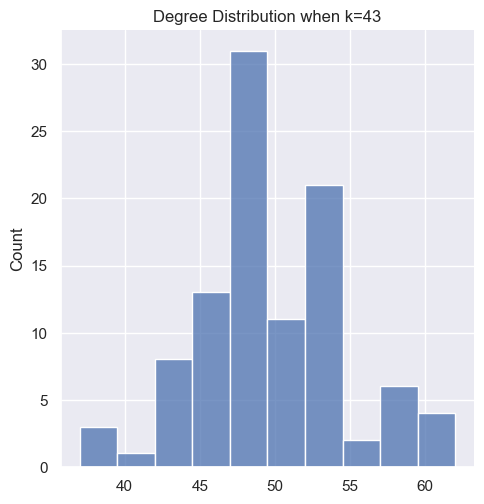

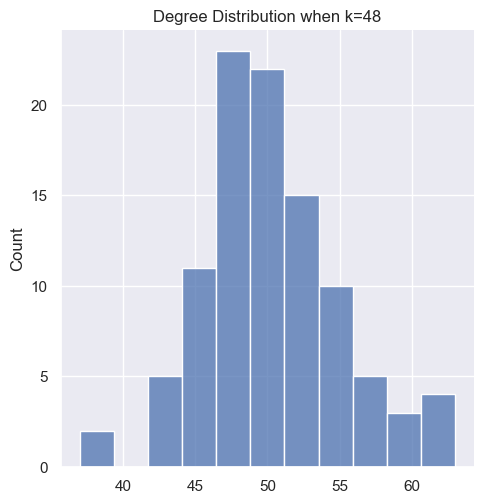

In [49]:
rx_deg = {}
for i, a in enumerate(np.arange(3, identity_k, 5)):
    degree = rx_graphs[a].degree()
    mean = np.mean(degree)
    print(f'{a}:, mean: {mean}, variance:{np.var(degree)}')
    rx_deg[a] = degree - mean
    sns.displot(degree).set(title=f"Degree Distribution when k={a}")

rx

    3:, mean: 5.8, variance:4.14
    8:, mean: 14.78, variance:10.671599999999998
    13:, mean: 22.82, variance:11.427599999999998
    18:, mean: 29.86, variance:17.820399999999996
    23:, mean: 35.98, variance:24.2596
    28:, mean: 40.98, variance:22.599599999999995
    33:, mean: 44.66, variance:23.104400000000005
    38:, mean: 47.9, variance:22.109999999999996
    43:, mean: 49.86, variance:24.100399999999993
    48:, mean: 50.84, variance:22.534399999999994
    
    
vx

    3:, mean: 5.8, variance:2.68
    8:, mean: 14.78, variance:5.4916
    13:, mean: 22.82, variance:8.927600000000002
    18:, mean: 29.86, variance:9.260399999999999
    23:, mean: 35.98, variance:11.179599999999995
    28:, mean: 40.98, variance:11.399599999999998
    33:, mean: 44.66, variance:13.404399999999999
    38:, mean: 47.9, variance:14.39
    43:, mean: 49.86, variance:17.3204
    48:, mean: 50.84, variance:21.654399999999995